<a href="https://colab.research.google.com/github/omerhac/osic-fibrosis/blob/master/exponent_functions_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# images path
IMAGES_GCS_PATH = 'gs://osic_fibrosis/images'

In [2]:
# clone and copy repository
!git clone https://github.com/omerhac/osic-fibrosis.git
!cp -r osic-fibrosis/* ./

Cloning into 'osic-fibrosis'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 384 (delta 5), reused 9 (delta 3), pack-reused 368
Receiving objects: 100% (384/384), 55.02 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (235/235), done.


# View one prediction graph

In [3]:
import predict 
import visualize

# plot one patient predicted graph
#exp_gen = predict.exponent_generator(IMAGES_GCS_PATH + '/train')
#id, func = next(exp_gen)
#visualize.plot_patient_exp(id, exp_function=func)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Plot n_samples of ground truth exponent functions

In [4]:
import table_data
exp_dict = table_data.get_exp_fvc_dict()
train_table = table_data.get_train_table()

# create exponent functiosn dict
func_dict = {}
for id in exp_dict:
  i_week, i_fvc = table_data.get_initial_fvc(id)
  func_dict[id] = predict.ExpFunc(i_fvc, exp_dict[id], i_week)


<Figure size 1440x360 with 0 Axes>

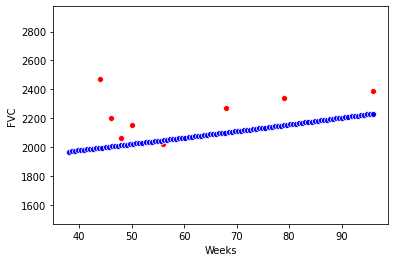

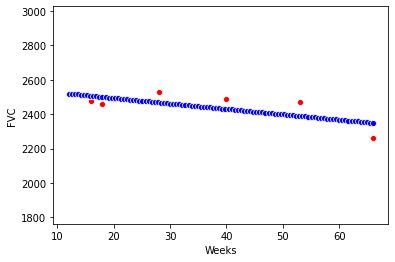

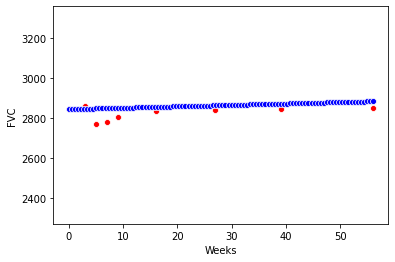

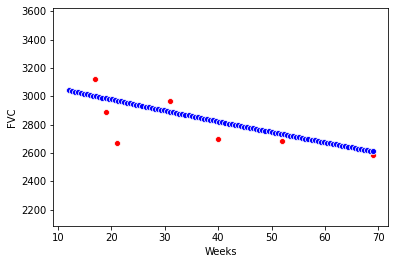

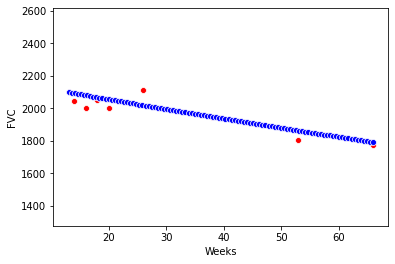

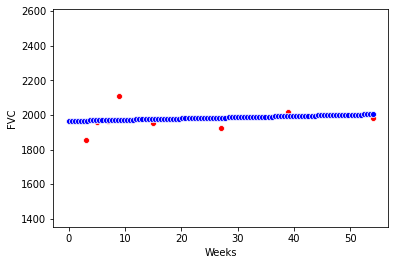

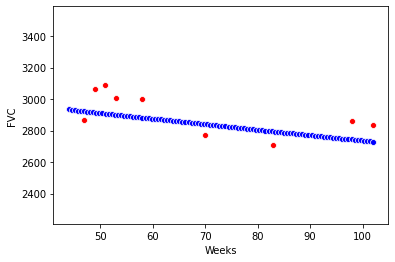

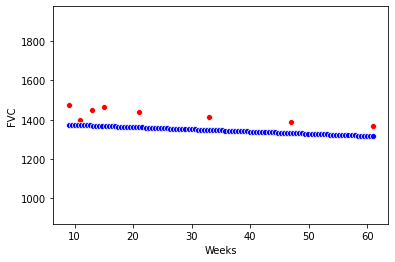

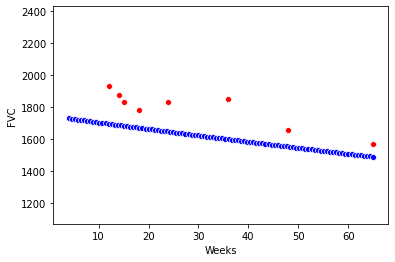

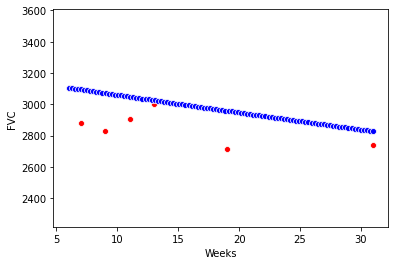

In [14]:
n_samples = 10

# plot
plt.figure(figsize=(20, 5))
for plot in range(n_samples):
  id = np.random.choice(list(func_dict))
  func = func_dict[id]
  visualize.plot_patient_exp(id, exp_function=func)

# Check Laplace Log Lokilhood for ground truth

In [27]:
import metrics

def metric_check(func_dict, n_patients, inifinite=False, theta=200):
    """Average n_patients random train patients Laplace Log Likelihood score"""
    scores = []

    # get scores
    for i, id in enumerate(func_dict):
        func = func_dict[id]

        # custom theta
        if isinstance(theta, dict):
          theta = theta[id]
        score = metrics.get_lll_value_exp_function(id, func, theta=theta)
        scores.append(score)

        # exit rule
        if inifinite:
            print(score) # for infinitely printing scores
        else:
            if i == n_patients - 1:
                break

    return sum(scores) / n_patients
  
  
metric_check(func_dict, 170)

-6.458519115560627

# Check how much effect does theta have

In [29]:
# get a very good theta 
theta_dict = {}

# iterate threw all train patients
for id in func_dict:
  hist = table_data.get_fvc_hist(train_table, id)
  theta = np.abs(hist["FVC"] - func_dict[id](hist["Weeks"])) # compute theta as the absolute diff of a prediction from ground truth
  theta_dict[id] = theta

metric_check(func_dict, 170, theta=theta_dict)

-0.03751443289100216

# Exemine outliers

ID00051637202185848464638


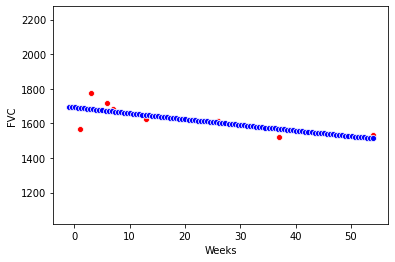

175    0.000135
176    0.508514
177    0.270428
178    0.052953
179    0.004382
180    0.010187
181    0.003370
182    0.128791
183    0.242929
Name: cooks_d, dtype: float64
ID00052637202186188008618


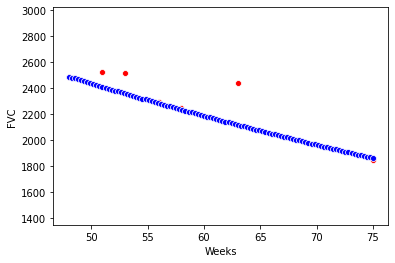

184    0.125859
185    0.010474
186    0.043820
187    0.044802
188    0.037041
189    0.473846
190    2.735403
Name: cooks_d, dtype: float64
ID00060637202187965290703


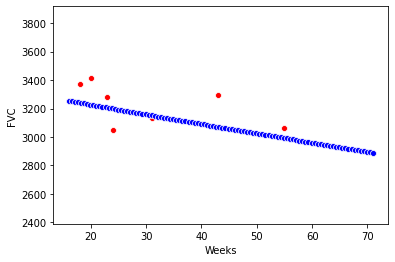

191    0.039568
192    0.049572
193    0.148296
194    0.002291
195    0.281911
196    0.028426
197    0.168612
198    0.003356
199    0.337765
Name: cooks_d, dtype: float64
ID00061637202188184085559


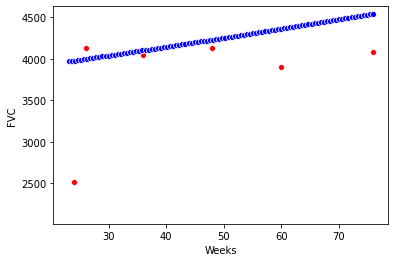

200    0.030451
201    0.817676
202    0.061932
203    0.023073
204    0.020631
205    0.010599
206    0.011347
207    0.018873
208    0.055409
Name: cooks_d, dtype: float64
ID00062637202188654068490


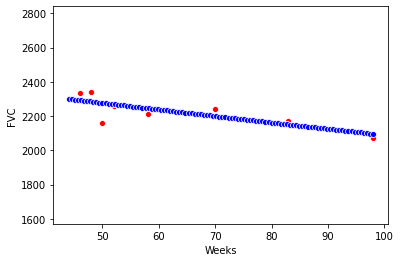

209    0.000932
210    0.097516
211    0.134119
212    0.442449
213    0.001186
214    0.022275
215    0.048466
216    0.045663
217    0.237571
Name: cooks_d, dtype: float64
ID00067637202189903532242


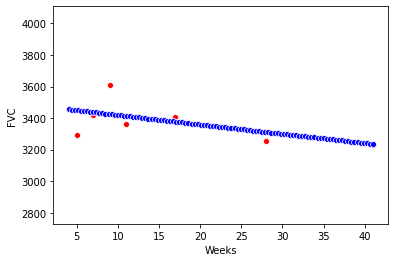

218    0.001593
219    0.346058
220    0.001011
221    0.383293
222    0.015815
223    0.013070
224    0.051961
225    0.004067
Name: cooks_d, dtype: float64
ID00068637202190879923934


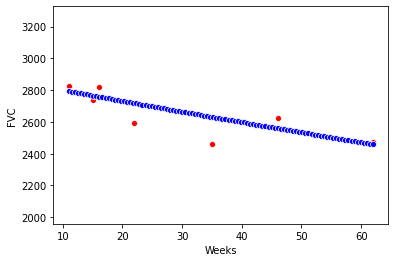

226    0.005793
227    0.048276
228    0.006879
229    0.001408
230    0.073430
231    0.119156
232    0.318640
233    0.208114
234    0.343174
Name: cooks_d, dtype: float64
ID00072637202198161894406


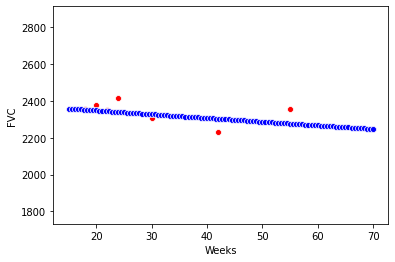

235    0.009276
236    0.002814
237    0.013493
238    0.000613
239    0.152231
240    0.030053
241    0.266865
242    0.520463
243    0.090881
Name: cooks_d, dtype: float64
ID00073637202198167792918


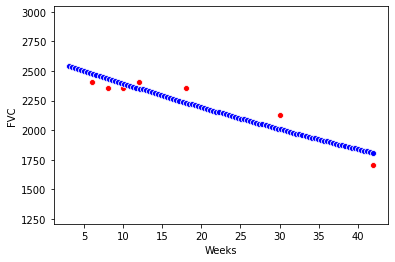

244    0.015092
245    0.082683
246    0.092675
247    0.026603
248    0.031468
249    0.120761
250    0.364927
251    3.694161
Name: cooks_d, dtype: float64
ID00075637202198610425520


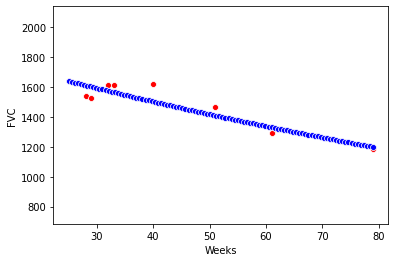

252    0.000072
253    0.180870
254    0.184499
255    0.022149
256    0.036943
257    0.186839
258    0.037875
259    0.131941
260    0.122775
Name: cooks_d, dtype: float64


In [7]:
from statsmodels.formula.api import ols

for id in train_table["Patient"].unique()[20:30]:
  print(id)
  hist = table_data.get_fvc_hist(train_table, id)
  m = ols("FVC ~ Weeks", hist).fit() # fit a statsmodels ols
  visualize.plot_patient_exp(id, func_dict[id])
  infl = m.get_influence() # check influens on every point
  outliers = infl.summary_frame()["cooks_d"] # show cooks distance for every point
  print(outliers)

# Case study: Patient "ID00007637202177411956430"

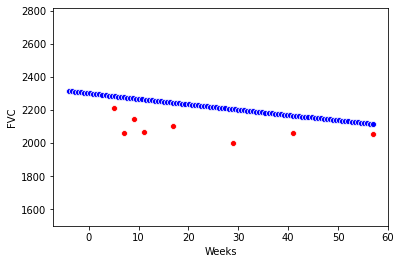

In [8]:
# visualize fvc
visualize.plot_patient_exp("ID00007637202177411956430")

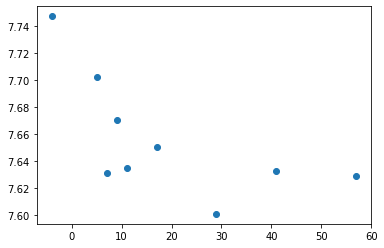

In [9]:
# visualize log of exp
hist = table_data.get_fvc_hist(train_table, "ID00007637202177411956430") # get hist
log_fvc = np.log(hist["FVC"])
plt.scatter(hist["Weeks"], log_fvc)

In [10]:
# show cooks distance
log_hist = hist.copy()
log_hist["FVC"] = log_fvc
m = ols("FVC ~ Weeks", log_hist).fit() # fit ols
infl = m.get_influence()
cooks_d = infl.summary_frame()["cooks_d"]
print(cooks_d)

0    0.688798
1    0.066837
2    0.147898
3    0.000002
4    0.068576
5    0.003643
6    0.114551
7    0.015588
8    1.040481
Name: cooks_d, dtype: float64


[0.951229424500714, 0.8589167013669103, 0.775562530852367, 0.7002975239681389, 0.6323366621862497, 0.5709711096494454, 0.515560819970764, 0.46552786051140055, 0.4203503845086819, 0.3795571881830896, 0.3427227960546276, 0.3094630232080927, 0.2794309682214073, 0.25231339496301824, 0.2278274655202903, 0.20571779018314462, 0.18575376371409136, 0.1677271601217968, 0.15144996085152654, 0.1367523937403634, 0.12348116228338321, 0.11149784674193076, 0.10067746041745854, 0.09090714603277736, 0.0820849986238988]


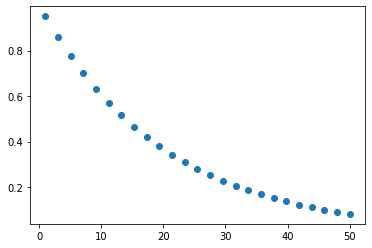

In [11]:
points = np.linspace(1, 50, 25)
y = [np.exp(-0.05 * point) for point in points]
print(y)
plt.scatter(points, y)

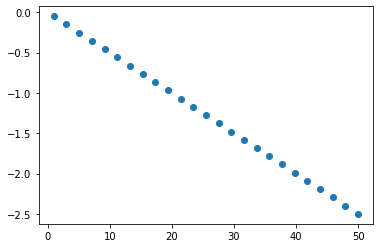

In [12]:
plt.scatter(points, np.log(y))